# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [4]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 20
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews


In [5]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | We are extremely grateful ...
1,✅ Trip Verified | I had an appalling experie...
2,"Not Verified | Good points, the cabin crew, t..."
3,"Not Verified | It was a decent flight, reason..."
4,✅ Trip Verified | I really like flying Briti...


In [7]:
df.to_csv("BA_reviews.csv")

In [8]:
df.head()

,reviews
0,✅ Trip Verified | We are extremely grateful ...
1,✅ Trip Verified | I had an appalling experie...
2,"Not Verified | Good points, the cabin crew, t..."
3,"Not Verified | It was a decent flight, reason..."
4,✅ Trip Verified | I really like flying Briti...


In [12]:
import re
#extract verification status
df['verified']= df['reviews'].apply(lambda x:'✅ Trip Verified' in x)

df['clean_text']= df['reviews'].apply(lambda x: re.sub(r'^(✅ Trip Verified \| |Not Verified \| )','',x))

df['airline']= 'British Airways'

In [18]:
df.head(100)

,reviews,verified,clean_text,airline
0,✅ Trip Verified | We are extremely grateful ...,True,✅ Trip Verified | We are extremely grateful ...,British Airways
1,✅ Trip Verified | I had an appalling experie...,True,I had an appalling experience with British A...,British Airways
2,"Not Verified | Good points, the cabin crew, t...",False,"Good points, the cabin crew, they were helpfu...",British Airways
3,"Not Verified | It was a decent flight, reason...",False,"It was a decent flight, reasonable comfortabl...",British Airways
4,✅ Trip Verified | I really like flying Briti...,True,I really like flying British Airways particu...,British Airways
...,...,...,...,...
95,✅ Trip Verified | Inefficient and slow airport...,True,Inefficient and slow airport operation. Restin...,British Airways
96,Not Verified | The customer service is one of...,False,The customer service is one of the worst I ha...,British Airways
97,"Not Verified | Before my flight, I was forced ...",False,"Before my flight, I was forced by the ground s...",British Airways
98,✅ Trip Verified | British Airways at its bes...,True,✅ Trip Verified | British Airways at its bes...,British Airways


In [21]:
print(f"total verified reviews: {df['verified'].sum()}({df['verified'].mean()*100:.1f}%)")

total verified reviews: 1327(66.3%)


In [23]:
df['word_count']= df['clean_text'].apply(lambda x:len(x.split()))
print(f"\n averange word count per review:{df['word_count'].mean():.1f} words")


 averange word count per review:163.7 words


In [30]:
from textblob import TextBlob

df['sentiment']= df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

df['sentiment_category']= pd.cut(df['sentiment'],
                                bins=[-1, -0.5, -0.1, 0.1, 0.5, 1],
                                labels=['very negative', 'negative','neutral','positive','very positive'])
print('\n sentiment distribution:')
print(df['sentiment_category'].value_counts(normalize=True).sort_index()*100)                                


 sentiment distribution:
very negative     0.50
negative         15.15
neutral          46.10
positive         36.60
very positive     1.65
Name: sentiment_category, dtype: float64


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer= CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

text_counts= vectorizer.fit_transform(df['clean_text'])

lda=LatentDirichletAllocation(n_components=6, random_state=30)
lda.fit(text_counts)

print("\n Main topic in review:")
feature_names= vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print (f'Topic {topic_idx + 1}:')
    print(" ".join([feature_names[i] for i in topic.argsort()[:-6:-1]]))


 Main topic in review:
Topic 1:
flight economy ba seat premium
Topic 2:
seat class seats business ba
Topic 3:
flight check london luggage gate
Topic 4:
flight ba crew service food
Topic 5:
flight ba customer british airways
Topic 6:
flight ba london staff service


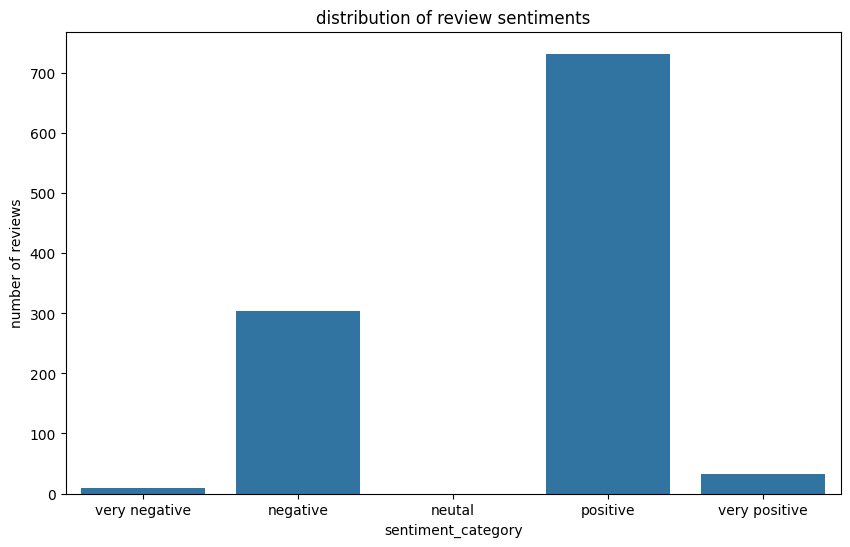

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data= df, x='sentiment_category', order=['very negative','negative','neutal','positive','very positive'])
plt.title('distribution of review sentiments')
plt.xlabel('sentiment_category')
plt.ylabel('number of reviews')
plt.show()


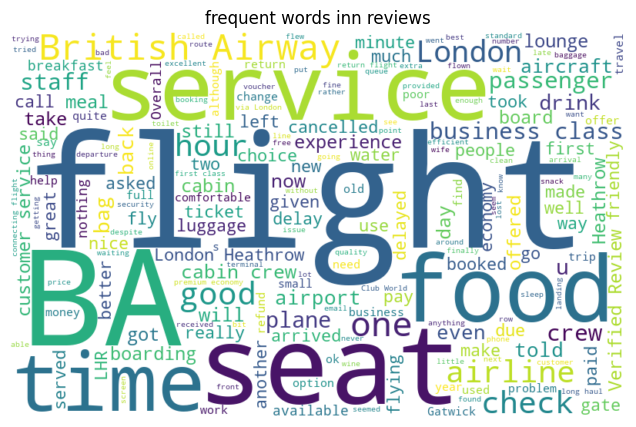

In [41]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(' '.join(df['clean_text']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('frequent words inn reviews')
plt.show()